In [2]:
import os
import numpy as np
import pyccl as ccl
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt
import libconf
# from scipy.integrate import simps
from scipy.integrate import simpson
from astropy.io import fits

import camb
from camb import model, initialpower
from __future__ import print_function
import treecorr
import fitsio
import time
import pprint
import pandas as pd
import camb
from camb import model
from camb.sources import SplinedSourceWindow
from scipy.special import erf

In [3]:
csm = {'omega_M': 0.31,
       'omega_B': 0.05,
       'omega_L': 1-0.31,
       'h': 0.6774,
       'w': -1.0,
       'ns': 0.967,
       'sigma_8': np.nan,
       'As': 2.142e-9}

def get_pk(csm, z_in):
    """
    get_pk(csm, z_in)
    Calculate the matter power spectrum, $\sigma_8$ and $f$ values, given a cosmological model

    Parameters
    ----------
    csm : dictionary - TO BE UPDATED HERE, sigma_8 value does not matter
        Keys must be ['omega_M', 'omega_B', 'omega_L', 'h', 'w', 'ns', 'sigma_8', 'As']
        encoding the values for[matter energy density, baryon energy density, dark energy energy density, 
            Hubble constant, dark energy constant, $\sigma_8$, primordial amplitude]
    z_in : array-like
        Array of redshifts to calculate

    Returns
    -------
    csm : With the $\sigma_8$ value updated, but otherwise the same
    kh : $k$ values (h units)
    pk : $P(k)$ values (h units)
    f : 
    """
    #Set up the fiducial cosmology
    pars = camb.CAMBparams()
    #Set cosmology
    pars.set_cosmology(H0=csm['h']*100, ombh2=csm['omega_B']*csm['h']**2, omch2=(csm['omega_M']-csm['omega_B'])*csm['h']**2,omk=0,mnu=0)
    pars.set_dark_energy() #LCDM (default)
    pars.InitPower.set_params(ns=csm['ns'], r=0, As=csm['As'])
    pars.set_matter_power(redshifts=[z_in], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 500)
    
    csm['sigma_8'] = float(results.get_sigma8())
    f = results.get_fsigma8()/csm['sigma_8']
    
    return csm, kh, pk[0], f[0]

def dndz_des_alonso(zi, amp=22.357, alpha=1.044, z0=0.568, beta=1.742):
    """
    dndz_des_alonso(zi, amp=22.357, alpha=1.044, z0=0.568, beta=1.742)
    Calculate the galaxy distribution function according to the fit done for the Alonso et. al. (???) curve.

    Parameters
    ----------
    zi : float, array-like
        Redshift values for which to calculate the galaxy distribution
    amp : float, default = 22.357
        Amplitude of the function
    alpha : float, default = 1.044
    z0 : float, default = 0.568
        Redshift distribution peak
    beta : float, default = 1.742

    Returns
    -------
    dndz : float, array-like
        Values in $\deg^{-2}$ of $dn/dz$
    """
    return amp*(zi/z0)**alpha*np.exp(-(zi/z0)**beta)*3600/100


def _gen_random_catalogue_theta(RA_min, RA_max, DEC_min, DEC_max, Npoints, seed=None):
    # Code from Pedro Fanha
    # generates a region populated with Npoints random points
    # RA_min, RA_max, DEC_min, DEC_max are floats (limits of square region)
    # Npoints integer (number of points to generate in the random)
    # seed (optional, set it to generate a specific distribution of points)
    
    # https://math.stackexchange.com/questions/711594/uniform-sampling-from-part-of-sphere-surface
    # RA in [0, 360[, DEC in [-90, 90[

    # TO DO: are there any built in functions in scipy stats to do this (inverse CDF?)

    rng = np.random.default_rng(seed)

    # select u, v in region of angles that I want
    phi_min = RA_min/180*np.pi
    phi_max = RA_max/180*np.pi
    
    u_min = phi_min/(2*np.pi)
    u_max = phi_max/(2*np.pi)

    # calculations take phi -> ra (0 to 2pi) ==> u
    # and theta -> dec (0 to pi) ==> v + theta = 0 corresponds to z axis, declination starts at equator
    theta_min_2 = (90 - DEC_min)/180*np.pi
    theta_max_2 = (90 - DEC_max)/180*np.pi
    
    v_min = (np.cos(theta_min_2) + 1)/2
    v_max = (np.cos(theta_max_2) + 1)/2

    u = u_min + (u_max - u_min)*rng.uniform(0, 1, size=Npoints)
    v = v_min + (v_max - v_min)*rng.uniform(0, 1, size=Npoints)

    # transform from u, v to angles phi, theta and then to RA, DEC (convert to degree)
    ra = 2*np.pi*u
    ra_deg = ra/np.pi*180
    dec = np.pi/2 - np.arccos(2*v - 1)
    dec_deg = dec/np.pi*180

    return pd.DataFrame({'RA': ra_deg % 360, 'DEC': dec_deg})


def W_err(z,smooth):
    """
    W_err(z, zc, sz, smooth)
    Calculates a error function based window function

    Parameters
    ----------
    z: array-like
        Redshift values for which to calculate the window function
    smooth: float
        Controls how sharp the fall-off is

    Returns
    -------
    Ws: array-like
        The error function values
    """

    zc = (z[-1] - z[0]) / 2
    sz = zc - z[0]
    return (erf((zc+sz-z)/(np.sqrt(2)*smooth))-erf((zc-sz-z)/(np.sqrt(2)*smooth)))/2


In [4]:
def make_colore(csm, k_h, pk_h, n_grid, n_bins, zs, bias, output, dn_dz=None, tz=None):
    """
    make_colore(csm, n_grid, zs, bias, dndz=0, tz=0)
    Create desired CoLoRe simualtions (either photometric catalog or temperature maps)

    Parameters
    ----------
    csm : dictionary
        Keys must be ['omega_M', 'omega_B', 'omega_L', 'h', 'w', 'ns', 'sigma_8', 'As']
        encoding the values for[matter energy density, baryon energy density, dark energy energy density, 
            Hubble constant, dark energy constant, $\sigma_8$, primordial amplitude]
    k_h : array-like
        Range of $k$ (in $h$ units) values for which the matter power spectrum is determined
    pk : array-like
        Power spectrum values for the $k$ values
    n_grid : integer, power of 2
        Resolution of the simulation
    n_bins : positive integer
        Number of redshift bins to separate simulation in.
    zs : array-like
        Array of values of redshift to encompass in the simulation.
    bias : array-like
        Must have same size as zs. Contains the observation bias function.
    output: string, 'galaxies' or 'HIIM'
        Determines wether the output of CoLoRe is a galaxy catalog or HI intensity map.
    dndz : deg^-2, array-like, optional, default = None
        Array to be used if goal is phometric galaxy catalog. 
        If used, must have the same size as 'zs' and contain the galaxy distribution function.
    tz :  : mK, array-like, optional, default = None
        Array to be used if goal is temperature maps. 
        If used, must have the same size as 'zs' and contain the background temperature data.

    Returns
    -------
    The desired map in a sub-directory. If photometry catalog, '\sources', if H1IM, '\maps'
    return : string
        String containing directions to the path of the maps
    """

    config = {}
    
    if output=='galaxies':
        if dn_dz is None:
            raise ValueError("dn_dz must be provided for galaxies output")
        dirname_out = 'sources'
        os.system(f'mkdir -p {dirname_out}')
        np.savetxt(f'{dirname_out}/dndz.txt', np.transpose([zs, dn_dz]))
        final_file = '/colore_srcs_s1_....fits'
        
        config['srcs1'] = {'nz_filename': f'{dirname_out}/dndz.txt',
                           'bias_filename': f'{dirname_out}/bias.txt',
                           'include_lensing': True,
                           'store_skewers': False}
    
    if output=='HIIM':
        if tz is None:
            raise ValueError("tz must be provided for temperature output")
        dirname_out = 'maps'
        os.system(f'mkdir -p {dirname_out}')
        np.savetxt(f'{dirname_out}/tz.txt', np.transpose([zs, tz]))
        nu_ref = 1420.
        nu0 = nu_ref / (1+float(zs[-1]))
        nu1 = nu_ref / (1+float(zs[0]))
        nu_arr = np.linspace(nu0, nu1, n_bins+1)
        np.savetxt(f'{dirname_out}/nuTable.txt', np.transpose([nu_arr[:-1], nu_arr[1:]]))
        final_file = '/colore_imap_s1_nu....fits'

        config['imap1'] = {'tbak_filename': f'{dirname_out}/tz.txt',
                           'bias_filename': f'{dirname_out}/bias.txt',
                           'freq_list': f'{dirname_out}/nuTable.txt',
                           'freq_rest': float(nu_ref),
                           'nside': float(n_grid)}

    np.savetxt(f'{dirname_out}/bias.txt', np.transpose([zs, bias]))
    np.savetxt(f'{dirname_out}/pk.txt', np.transpose([k_h, pk_h]))

    if zs[0]>0:
        z_min = zs[0]
    else:
        z_min=0.001
    
    config['global'] = {'prefix_out': dirname_out + '/colore',
                        'output_format': 'FITS',
                        'output_density': True,
                        'pk_filename': f'{dirname_out}/pk.txt',
                        'z_min': float(z_min),
                        'z_max': float(zs[-1]),
                        'seed': 1000,
                        'write_pred': False,
                        'just_write_pred': False}
    config['field_par'] = {'r_smooth': 1.,
                        'smooth_potential': True,
                        'n_grid': float(n_grid),
                        'dens_type': 1,
                        'lpt_buffer_fraction': 0.6,
                        'lpt_interp_type': 1,
                        'output_lpt': 0}
    # config['cosmo_par'] = csm

    if isinstance(csm, dict):
        csm_converted = {}
        for key, value in csm.items():
            if isinstance(value, np.ndarray):
                if value.size == 1:
                    csm_converted[key] = float(value.item())
                else:
                    csm_converted[key] = value.tolist()
            else:
                csm_converted[key] = value
        config['cosmo_par'] = csm_converted
    else:
        config['cosmo_par'] = csm
    with open(f'{dirname_out}/params.cfg', 'w') as configfile:
        libconf.dump(config, configfile)
    print(dirname_out + ' map saved in ' + dirname_out + final_file)
    os.system(f'../CoLoRe/CoLoRe {dirname_out}/params.cfg > {dirname_out}/log.txt')
    f = open(f'{dirname_out}/log.txt', 'r')
    print(f.read())
    f.close()


def make_treecorr_sources(file_path):
    """
    make_treecorr_sources(file_path)
    Calculates the angular correlation function of the source map provided

    Parameters
    ----------
    file_path : string
        Path to CoLoRe source map

    Returns
    -------
        r : array-like
            Array of separation values
        xi : array-like
            Angular correlation function values for the 'r' separations
        varxi : array-like
            Variance of the correlation function values
    """
    cat = fits.open(file_path)[1].data

    cat_sources = treecorr.Catalog(ra=cat["RA"], dec=cat["DEC"], 
                                   ra_units='deg', dec_units='deg')
    
    DD = treecorr.NNCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
    RR = treecorr.NNCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
    DR = treecorr.NNCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
    RD = treecorr.NNCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
    DD.process(cat_sources)

    n_pts_rand = int( 5 * len (cat["RA"]))

    df_sky_pos = _gen_random_catalogue_theta( RA_min=0, RA_max=360, DEC_min=-90, DEC_max=90, Npoints=n_pts_rand, seed=7+15*10 )
    cat_random = treecorr.Catalog(ra=df_sky_pos["RA"], dec=df_sky_pos["DEC"], 
                                  ra_units='degrees', dec_units='degrees')
    RR.process(cat_random)
    DR.process(cat_sources, cat_random)
    RD.process(cat_random, cat_sources)

    xi, varxi  = DD.calculateXi(rr=RR, dr=DR, rd=RD)

    r = np.exp(DD.meanlogr)

    return r, xi, varxi

def make_treecorr_maps(file_path):
    """
    make_treecorr_maps(file_path)
    Calculates the angular correlation function of the temperature map provided

    Parameters
    ----------
    file_path : string
        Path to CoLoRe temperature map

    Returns
    -------
        r : array-like
            Array of separation values
        xi : array-like
            Angular correlation function values for the 'r' separations
        varxi : array-like
            Variance of the correlation function values
    """
    cat = hp.read_map(file_path)
    mean = np.average(cat)
    delta = cat-mean

    nside = hp.get_nside(delta)
    npix = hp.get_map_size(delta)
    pixel_indices = np.arange(npix)
    theta, phi = hp.pix2ang(nside, pixel_indices)
    ra = np.degrees(phi)
    dec = 90.0 - np.degrees(theta)

    cat_imap = treecorr.Catalog(ra=ra, dec=dec, k=delta, 
                                    ra_units='deg', dec_units='deg')
    
    KK = treecorr.KKCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
    KK.process(cat_imap)

    r = np.exp(KK.meanlogr)
    xi = KK.xi
    varxi = KK.varxi

    return r, xi, varxi

def make_treecorr_corr(photo_map_path, temp_map_path):
    """
    make_treecorr_corr(photo_map_path, temp_map_path)
    Calculates the angular cross-correlation function of the source and temperature maps provided

    Parameters
    ----------
    photo_map_path : string
        Path to CoLoRe source map
    temp_map_path : string
        Path to CoLoRe temperature map

    Returns
    -------
        r : array-like
            Array of separation values
        xi : array-like
            Angular correlation function values for the 'r' separations
        varxi : array-like
            Variance of the correlation function values    
    """

    imap = hp.read_map(temp_map_path)
    med_T=np.average(imap)
    delta=imap-med_T
    nside = hp.get_nside(delta)
    npix = hp.get_map_size(delta)
    pixel_indices = np.arange(npix)
    theta, phi = hp.pix2ang(nside, pixel_indices)
    ra = np.degrees(phi)
    dec = 90.0 - np.degrees(theta)

    catalog_imap = treecorr.Catalog(ra=ra, dec=dec, k=delta, 
                                    ra_units='deg', dec_units='deg')

    cat = fits.open(photo_map_path)[1].data
    catalog_sources = treecorr.Catalog(ra=cat["RA"], dec=cat["DEC"], 
                                       ra_units='deg', dec_units='deg')


    NK = treecorr.NKCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
    NK.process(catalog_sources, catalog_imap)

    xi, varxi = NK.calculateXi()

    r = np.exp(NK.meanlogr)

    return r, xi, varxi


def make_camb(csm, lmax, zs, Ws, bias, cross = False):
    """
    make_camb(csm, lmax, zs, Ws, bias, cross = False)
    Create the theoretical $C_\ell$ values for a given cosmology and set of space

    Parameters
    ----------
    csm : dictionary
        Keys must be ['omega_M', 'omega_B', 'omega_L', 'h', 'w', 'ns', 'sigma_8', 'As']
        encoding the values for[matter energy density, baryon energy density, dark energy energy density, 
            Hubble constant, dark energy constant, $\sigma_8$, primordial amplitude]
    lmax : integer
        Maximum scale to consider
    zs : array-like
        Redshift values over which to calculate the power spectrum
    Ws : array-like
        Mask on the detection
    bias : array-like
        Bias observation function
    cross : boolean, default = False
        If False, will perform auto-correlation, and 'zs', 'Ws' and 'bias' must be 1D-arrays.
        If True, will perform cross-correlation, and 'zs', 'Ws' and 'bias' must be 2D-arrays.
    
    Returns
    -------
    ls : array-like
        List of $\ell$ values, [2:lmax+1]
    cls : array-like
        Raw $C_\ell$ values
    """

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=csm['h']*100, ombh2=csm['omega_B']*csm['h']**2, omch2=(csm['omega_M']-csm['omega_B'])*csm['h']**2)
    pars.InitPower.set_params(As=csm['As'], ns=csm['ns'])
    pars.set_for_lmax(lmax, lens_potential_accuracy=1)
    pars.Want_CMB = False
    pars.NonLinear = model.NonLinear_both

    if cross:
        pars.SourceWindows = [SplinedSourceWindow(z = zs[0], W = Ws[0], bias_z = bias[0]),
                              SplinedSourceWindow(z = zs[1], W = Ws[1], bias_z = bias[1])]
        map = 'W1xW2'
    else:
        pars.SourceWindows = [SplinedSourceWindow(z = zs, W = Ws, bias_z = bias)]
        map = 'W1xW1'

    results = camb.get_results(pars)
    cls = results.get_source_cls_dict(raw_cl=True)[map][2 : lmax + 1]
    ls = np.arange(2, lmax+1)

    return ls, cls

def make_w_theta(csm, ls, cls, theta):
    """
    make_w_theta(csm, ls, cls, theta)
    Determine theoretical angular correlation function

    Parameters
    ----------
    csm : dictionary
        Keys must be ['omega_M', 'omega_B', 'omega_L', 'h', 'w', 'ns', 'sigma_8', 'As']
        encoding the values for[matter energy density, baryon energy density, dark energy energy density, 
            Hubble constant, dark energy constant, $\sigma_8$, primordial amplitude]
    ls : array-like
        List of $\ell$ values
    cls : array-like
        Corresponding list of **treated** $C_\ell$ values, meaning they must aleady include shot noise terms, for example.
    theta : array-like
        Array of theta separation values to examine

    Returns
    -------
    wtheta : array-like
        Angular correlation function values
    """
    
    cosmo = ccl.Cosmology(Omega_c=csm['omega_M']-csm['omega_B'],
                      Omega_b=csm['omega_B'],
                      h=csm['h'],
                      sigma8=csm['sigma_8'],
                      n_s=csm['ns'],
                      transfer_function='eisenstein_hu')

    wtheta = ccl.correlation(cosmo, ell=ls, C_ell=cls, 
                         theta=theta, type='NN', method='FFTLog')
    
    return wtheta

In [11]:
zs = np.linspace(0.55, 0.85, 30)
dndz = dndz_des_alonso(zs)
t_z = 0.05 * np.ones_like(zs)
n_bins = 1
n_grid = 256
bias = np.ones_like(zs)
csm, kh, pkh, f = get_pk(csm, 0.0)
Ws=W_err(zs,0.01)

/tmp/ipykernel_253964/1418618599.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  csm['sigma_8'] = float(results.get_sigma8())


In [12]:
make_colore(csm, kh, pkh, n_grid, n_bins, zs, bias, 'galaxies', dn_dz = dndz)
make_colore(csm, kh, pkh, n_grid, n_bins, zs, bias, 'HIIM', tz = t_z)

sources map saved in sources/colore_srcs_s1_....fits
MPI task 0, OMP thread count starts at 0
 MPIThreadsOK = 1

|-------------------------------------------------|
|                      CoLoRe                     |
|-------------------------------------------------|

The cosmological model is:
 O_M=0.310 O_L=0.690 O_K=0.000
 O_B=0.050 w=-1.000 h=0.677
 Flat universe, standard cosmological constant

 Time of equality: a_eq=0.76610
 Particle horizon: chi_H(0)=9.777E+03 Mpc/h
 Present growth factor: D_0=0.785

Reading P_k from file: sources/pk.txt
  Original sigma8=0.825871
  Sigma_Gauss should be 0.503451
Node 0 will allocate 0.348 GB [0.190 GB (Gaussian), 0.302 GB (1LPT), 17179869183.856 GB (srcs)]

Run parameters: 
  0.550 < z < 0.850
  1429.546 < r/(Mpc/h) < 2035.002
  L_box = 4101.801 Mpc/h, N_grid = 256 
  Scales resolved: 1.532E-03 < k < 1.953E-01 h/Mpc
  Fourier-space resolution: dk = 1.532E-03 h/Mpc
  Real-space resolution: dx = 1.602E+01 Mpc/h
  Density field pre-smoothed on s

In [14]:
from astropy.io import fits

# Open and inspect the intensity map file
with fits.open('maps/colore_imap_s1_nu000.fits') as hdul_imap:
    hdul_imap.info()  # This prints a summary of all HDUs in the file
    # Print the data from the first HDU
    if hdul_imap[1].data is not None:
        print("Shape of data in HDU 1:", hdul_imap[1].data.shape)
        print("First few rows of data:\n", hdul_imap[1].data[:5])

# Open and inspect the galaxy source file
with fits.open('sources/colore_srcs_s1_0.fits') as hdul_src:
    hdul_src.info()
    if hdul_src[1].data is not None:
        print("Shape of data in HDU 1:", hdul_src[1].data.shape)
        print("Column names:", hdul_src[1].data.names)
        print("First few rows:\n", hdul_src[1].data[:5])

Filename: maps/colore_imap_s1_nu000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  BINTABLE      1 BinTableHDU     17   786432R x 1C   [1E]   
Shape of data in HDU 1: (786432,)
First few rows of data:
 [(nan,) (nan,) (nan,) (nan,) (nan,)]
Filename: sources/colore_srcs_s1_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     39   2029587R x 10C   [1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E!, 1E]   
Shape of data in HDU 1: (2029587,)
Column names: ['TYPE', 'RA', 'DEC', 'Z_COSMO', 'DZ_RSD', 'E1', 'E2', 'KAPPA', 'DRA', 'DDEC']
First few rows:
 [(0, 271.66165, -87.45965 , 0.78591746,  0.00058251, -0.00070232, 0.00163778, -0.00466477,  0.00266763, 0.00815892)
 (0, 287.37015, -88.21714 , 0.7862959 ,  0.00079478,  0.0009827 , 0.00273543, -0.00576463,  0.00231905, 0.00305978)
 (0, 283.34885, -87.94618 , 0.77924174, -0.00015855

In [7]:
r_sources, xi_sources, varxi_sources = make_treecorr_sources('./sources/colore_srcs_s1_0.fits')
r_temp, xir_temp, varxir_temp = make_treecorr_maps('./maps/colore_imap_s1_nu000.fits')
r_both, xi_both, varxi_both = make_treecorr_corr('./sources/colore_srcs_s1_0.fits', './maps/colore_imap_s1_nu000.fits')

ValueError: Catalog has invalid sumw == 0

In [8]:
Ws_cross = [Ws, Ws]
zs_cross = [zs, zs]
bias_cross = [bias, bias]
ls, cls = make_camb(csm, 5000, zs, Ws, bias, cross=False)
ls_cross, cls_cross = make_camb(csm, 5000, zs_cross, Ws_cross, bias_cross, cross=True)


In [9]:
cat = fits.open("sources/colore_srcs_s1_0.fits")[1].data
n_dens = len(cat['RA'])/(4*np.pi)
wtheta_sources = make_w_theta(csm, ls, cls + 1/n_dens, r_sources)
wtheta_temp = make_w_theta(csm, ls, cls*0.05**2, r_temp)
wtheta_both = make_w_theta(csm, ls_cross, cls_cross, r_both)


NameError: name 'r_temp' is not defined

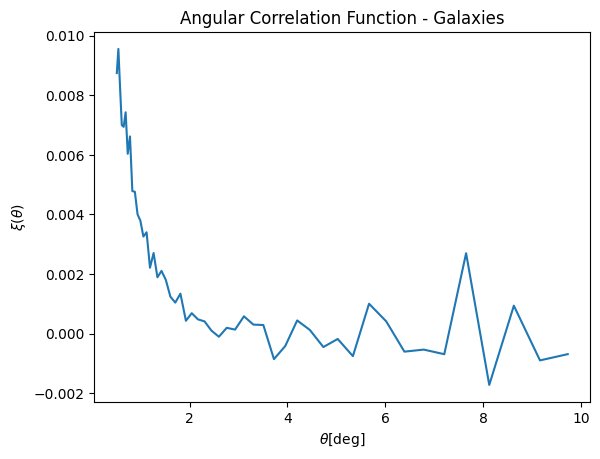

NameError: name 'r_temp' is not defined

In [10]:
plt.plot(r_sources, xi_sources)
plt.xlabel(r'$\theta [\deg]$')
plt.ylabel(r'$\xi(\theta)$')
plt.title('Angular Correlation Function - Galaxies')
plt.show()
plt.plot(r_temp, xi_temp)
plt.xlabel(r'$\theta [\deg]$')
plt.ylabel(r'$\xi(\theta)$')
plt.title('Angular Correlation Function - HIIM')
plt.show()
plt.plot(r_sources, xi_sources)
plt.xlabel(r'$\theta [\deg]$')
plt.ylabel(r'$\xi(\theta)$')
plt.title('Angular Correlation Function - Cross')
plt.show()

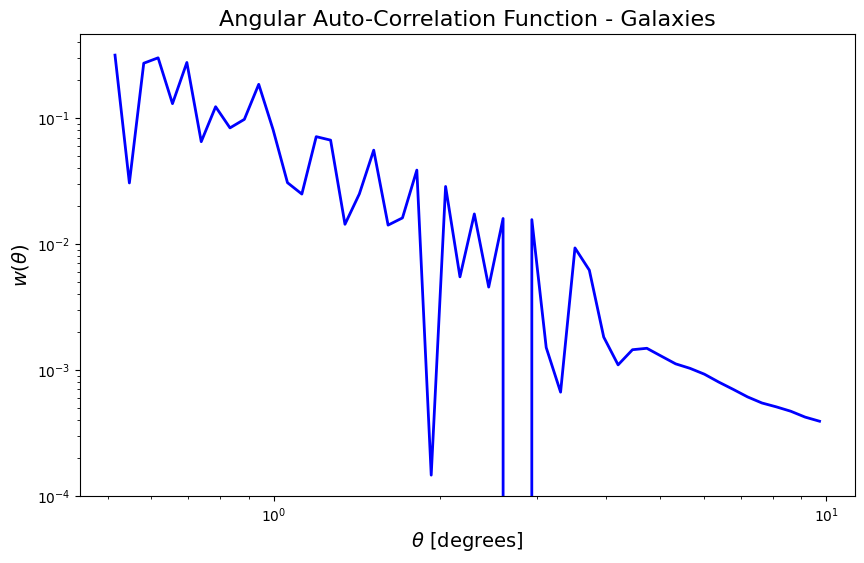

NameError: name 'r_temp' is not defined

<Figure size 1000x600 with 0 Axes>

In [11]:
plt.figure(figsize=(10, 6))
plt.loglog(r_sources, wtheta_sources, 'b-', linewidth=2)
plt.xlabel(r'$\theta$ [degrees]', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Auto-Correlation Function - Galaxies', fontsize=16)
plt.show()
plt.figure(figsize=(10, 6))
plt.loglog(r_temp, wtheta_temp, 'b-', linewidth=2)
plt.xlabel(r'$\theta$ [degrees]', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Auto-Correlation Function - HIIM', fontsize=16)
plt.show()
plt.figure(figsize=(10, 6))
plt.loglog(r_both, wtheta_both, 'b-', linewidth=2)
plt.xlabel(r'$\theta$ [degrees]', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Cross-Correlation Function - Galaxies vs HIIM', fontsize=16)
plt.show()